**Objective**
* Build a `binary-classifier` that predicts whether a person is likely to have a heart attack (1) or not (0)
* **Data Features:**
    * `age`: Patient age.
    * `gender`: Patient gender (Unspecified).
    * `chest_pain_type`: Chest Pain type chest pain type.
        * Typical angina.
        * Atypical angina.
        * Non-anginal pain.
        * Asymptomatic.
    * `rest_blood_pressure`: Resting blood pressure (in mm Hg).
    * `cholesterol`: Cholesterol in mg/dl fetched via BMI sensor.
    * `fast_blood_sugar`: Fasting blood sugar > 120 mg/dl.
    * `rest_ecg`: Resting electrocardiographic results.
        * Normal.
        * Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV).
        * Showing probable or definite left ventricular hypertrophy by Estes' criteria.
    * `max_heart_rate`: Maximum heart rate achieved.
    * `ex_ind_ang`: Exercise induced angina (Yes, No).
    * `prev_peak`: Old peak.
    * `slope`: Slope.
    * `vessels_num`: Number of major vessels (0-3).
    * `thal_result`: Thalium Stress Test result.
    * `output`: 0 = less chance of heart attack, 1 = more chance of heart attack.

**ML Workflow**
* PREPARING DATA
    * Importing 
    * Exploring
    * Splitting
* BUILDING MODELS
    * Baselining
    * Iterating
    * Evaluating
* COMMUNICATING RESULTS

In [1]:
# importing necessary libraries

# to measure time elapsed
import time

# for matrix-array and data analysis
import numpy as np
import pandas as pd

# for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# for encoding categorical data
from category_encoders import OneHotEncoder

# for model building, Hyperparameter Tuning and and Cross Validation
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

# predictors for Binary Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# for model evaluation
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, log_loss, RocCurveDisplay

# 1. Preparing Data

## 1.1 Importing Data

In [2]:
# Importing data from a .csv file and saving it to the dataframe `df`
df = pd.read_csv('take_home_assign_set[1630].csv')
# printing shape of dataframe
print(df.shape)
# Checking top 5 rows
df.head()

(303, 14)


,age,gender,chest_pain_type,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,ex_ind_ang,prev_peak,slope,vessels_num,thal_result,output
0,63,1,Non-anginal pain,145,233,Yes,Normal,150,No,2.3,0,0,1,1
1,37,1,Atypical angina,130,250,No,ST-T wave normality,187,No,3.5,0,0,2,1
2,41,0,Typical angina,130,204,No,Normal,172,No,1.4,2,0,2,1
3,56,1,Typical angina,120,236,No,ST-T wave normality,178,No,0.8,2,0,2,1
4,57,0,NaN,120,354,No,ST-T wave normality,163,Yes,0.6,2,0,2,1


## 1.2 Exploring Data

### Checking Class Balance for Target Vector `output`
* The Target Vector here is `output` feature
    * 0 - Less chance of Heart Attack
    * 1 - More chance of Heart Attack
* Must check if these Classes are balanced because if they are not, Resampling would be required

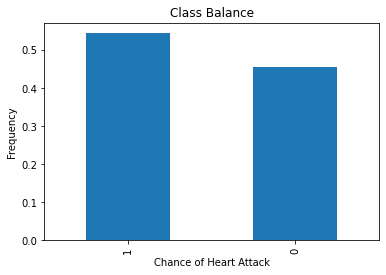

In [3]:
# Plotting bar chart for normalised value counts of `output` column
df['output'].value_counts(normalize=True).plot(
    kind = 'bar',
    xlabel = 'Chance of Heart Attack',
    ylabel = 'Frequency',
    title = 'Class Balance'
);

* It turns out that the Classes are fairly balanced. No need to Re-Sample data
* **POSITIVE CLASS** - where `output` is 1 i.e. A higher chance of heart attack - is the **MAJORITY CLASS** here
* **NEGATIVE CLASS** - `output` is 0 i.e. Less chance of Heart Attack - is the **MINORITY CLASS** 

### Inspecting data for Missing Values

In [4]:
# Checking information about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  303 non-null    int64  
 1   gender               303 non-null    int64  
 2   chest_pain_type      160 non-null    object 
 3   rest_blood_pressure  303 non-null    int64  
 4   cholesterol          303 non-null    int64  
 5   fast_blood_sugar     303 non-null    object 
 6   rest_ecg             303 non-null    object 
 7   max_heart_rate       303 non-null    int64  
 8   ex_ind_ang           303 non-null    object 
 9   prev_peak            303 non-null    float64
 10  slope                303 non-null    int64  
 11  vessels_num          303 non-null    int64  
 12  thal_result          303 non-null    int64  
 13  output               303 non-null    int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 33.3+ KB


* It turns out that the feature `chest_pain_type` has a lot of missing values
* The rows with empty values for `chest_pain_type` can not be deleted because dataset is already small
* This feature can not either **not** be used for predictions,  because type of chest pain clearly seems like an important predictor feature for a heart attack. So it needs to stay

In [5]:
# Checking value counts and null values for `chest_pain_type`
print('Missing Values',df['chest_pain_type'].isnull().sum())
df['chest_pain_type'].value_counts()

Missing Values 143


Atypical angina     87
Typical angina      50
Non-anginal pain    23
Name: chest_pain_type, dtype: int64

* If this feature is imputed using the most frequent entries, that could lead to a skewed balance in favour of Atypical angina
* It was attempted to Ordinally Encode this feature and impute the missing values with KNNImputer, but that led to absurd values e.g. 0.85, 0.70, 0.45.. 
* That will not suit the purpose, because all possible values can fit in four categories as described: `Non-anginal Pain`, `Atypical angina`, `Typical angina`, `Asymptomatic`
* One Noteworthy point is that there are no rows with `Asymptomatic` as `chest_pain_type`. But, it would be a huge leap of faith to impute all NaN values with `Asymptomatic`
* **Missing values themselves could be valuable information**
* For now, create a new boolean feature `missing_chest_pain_type` which displays `True` for the rows with missing `chest_pain_type` values
    * Let OneHotEncoder deal with missing values in `chest_pain_type` column

**NOTE for self**
* Explore `ColumnEncoder` from [datawig](https://datawig.readthedocs.io/en/latest/source/userguide.html#examples) library to impute categorical variables

In [6]:
# Creating a new feature column `missing_chest_pain_type`
df['missing_chest_pain_type'] = (df['chest_pain_type'].isna()).astype(object)

### Checking number of unique values for all Features

In [7]:
# Counting unique values for each feature
df.nunique(axis = 0)

age                         41
gender                       2
chest_pain_type              3
rest_blood_pressure         49
cholesterol                152
fast_blood_sugar             2
rest_ecg                     3
max_heart_rate              91
ex_ind_ang                   2
prev_peak                   40
slope                        3
vessels_num                  5
thal_result                  4
output                       2
missing_chest_pain_type      2
dtype: int64

* Hold on, this does not make much sense
* Features `gender`, `slope`, `vessels_num`, `thal_result` take only limited values and their data type is `int64`
* But they clearly meet the criteria of categorical features
* Their data type must be converted to `object`

**Changing datatype of features which were categorical but mislabeled as numerical features**

In [8]:
df[['gender','slope','vessels_num','thal_result']] = df[['gender','slope','vessels_num','thal_result']].astype(str)

* There appears to be no problem with High Cardinality here because no categorical feature is different for all values
* But there seem to be quite a lot of categorical features with just 2-3 values
* It needs to be checked whether one value is dominating others or not

### Segmenting Categorical Features
**by `output`**
* It would be interesting to see what proportion of each category in every categorical feature is contributing to the `output` whether a person would have heart attack or not

In [9]:
for col in df.select_dtypes(include = 'object'):
    if df[col].nunique() <= 6:
        display(pd.crosstab(df['output'], df[col], normalize = 'index')) 

gender,0,1
output,,
0,0.173913,0.826087
1,0.436364,0.563636


chest_pain_type,Atypical angina,Non-anginal pain,Typical angina
output,,,
0,0.529412,0.205882,0.264706
1,0.547619,0.126984,0.325397


fast_blood_sugar,No,Yes
output,,
0,0.840580,0.159420
1,0.860606,0.139394


rest_ecg,Left ventricular hypertrophy,Normal,ST-T wave normality
output,,,
0,0.021739,0.572464,0.405797
1,0.006061,0.412121,0.581818


ex_ind_ang,No,Yes
output,,
0,0.449275,0.550725
1,0.860606,0.139394


slope,0,1,2
output,,,
0,0.086957,0.65942,0.253623
1,0.054545,0.29697,0.648485


vessels_num,0,1,2,3,4
output,,,,,
0,0.326087,0.318841,0.224638,0.123188,0.007246
1,0.787879,0.127273,0.042424,0.018182,0.024242


thal_result,0,1,2,3
output,,,,
0,0.007246,0.086957,0.260870,0.644928
1,0.006061,0.036364,0.787879,0.169697


missing_chest_pain_type,False,True
output,,
0,0.246377,0.753623
1,0.763636,0.236364


**OBSERVATIONS**
* Clearly there are some categories which have very few values e.g. in `slope` feature, **0** category is contributing very little to the final `output` feature.
* Similar case could be made for `vessels_num`. When number of vessels are greater than 1, their bearing on `output` decreases dramatically.
* This can also be seen in `thal_result` when results of Thalium Stress Test are less than 2.
* These sparse categories in their respective features, could be grouped with other features to help reduce noise in our predictions

### Consolidating and Creating new Categorical Features

#### for `thal_result`

In [10]:
# Converting back to integer to perform arithmetic manipulation
df['thal_result'] = df['thal_result'].astype(int)
# Creating a new feature With Categories which show whether Thalium Test Result was greater than 2 or Not
df['thal_result > 2'] = (df['thal_result'] > 2).astype(object)

#### for `slope`

In [11]:
df['slope'] = df['slope'].astype(int)
# Creating a new feature with categories which show whether slope was greater than 1 or not
df['slope > 1'] = (df['slope'] > 1).astype(object)

#### for `vessels_num`

In [12]:
df['vessels_num'] = df['vessels_num'].astype(int)
# Creating a new feature with categories which show whether number of major vessels was less than 1 or not
df['vessels_num < 1'] = (df['vessels_num'] < 1).astype(object)

**Dropping feature columns `thal_result`, `slope` and `vessels_num`**

In [13]:
df.drop(columns = ['thal_result','slope','vessels_num'], inplace = True)
df.head()

,age,gender,chest_pain_type,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,ex_ind_ang,prev_peak,output,missing_chest_pain_type,thal_result > 2,slope > 1,vessels_num < 1
0,63,1,Non-anginal pain,145,233,Yes,Normal,150,No,2.3,1,False,False,False,True
1,37,1,Atypical angina,130,250,No,ST-T wave normality,187,No,3.5,1,False,False,False,True
2,41,0,Typical angina,130,204,No,Normal,172,No,1.4,1,False,False,True,True
3,56,1,Typical angina,120,236,No,ST-T wave normality,178,No,0.8,1,False,False,True,True
4,57,0,NaN,120,354,No,ST-T wave normality,163,Yes,0.6,1,True,False,True,True


### Distribution of Categorical Features

**Summary Statistics**

In [14]:
# Checking Summary Statistics of Categorical Features
df.describe(include = 'object')

,gender,chest_pain_type,fast_blood_sugar,rest_ecg,ex_ind_ang,missing_chest_pain_type,thal_result > 2,slope > 1,vessels_num < 1
count,303,160,303,303,303,303,303,303,303
unique,2,3,2,3,2,2,2,2,2
top,1,Atypical angina,No,ST-T wave normality,No,False,False,False,True
freq,207,87,258,152,204,160,186,161,175


* It can be seen that for `fast_blood_sugar` feature, the most frequent value **No** occurs in over 85% of observations (258/303)
* This is an example of **Low Cardinality**
* The feature `fast_blood_sugar` needs to be dropped from Feature Matrix for predictions, because it would not be able to add much value

**Dropping `fast_blood_sugar` feature from DataFrame**

In [15]:
df.drop(columns = 'fast_blood_sugar', inplace = True)

### Distribution of Numerical Features
**Plotting Histogram and Scatter Plots for Numerical Features**

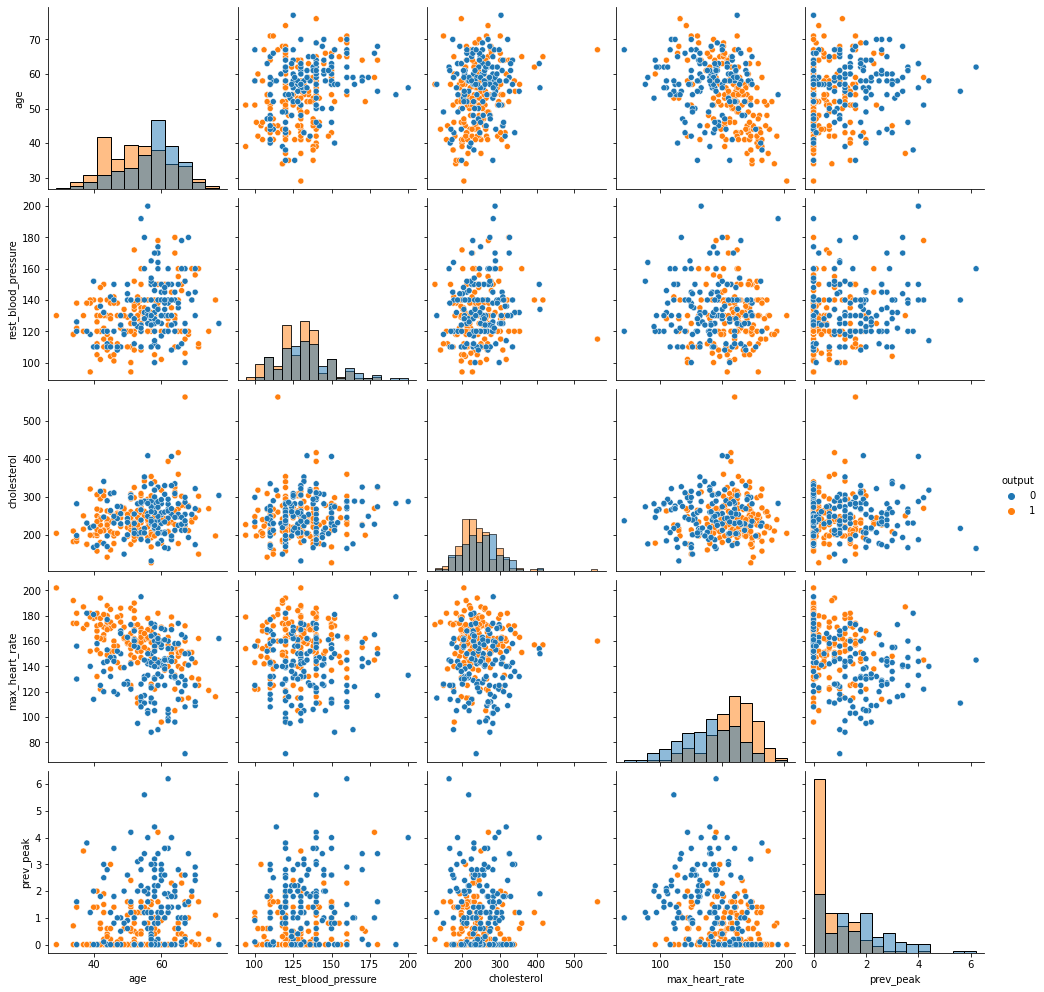

In [16]:
sns.pairplot(df.select_dtypes('number'),
             hue = 'output',
             diag_kind = 'hist',
             corner = False,
             height = 2.8
);

**Observations**
* There appear to be **outliers** in `cholesterol`, and `prev_peak` features. Further investigation required.
* `prev_peak` has the most skewed distribution. It could rank high in feature importances.
* No egregiously strong correlation between numerical features can be seen. But further checks necessary to decisively deal with multicollenearity 

**Summary Statistics for Numerical Features**

In [17]:
df.describe()

,age,rest_blood_pressure,cholesterol,max_heart_rate,prev_peak,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.544554
std,9.082101,17.538143,51.830751,22.905161,1.161075,0.498835
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,1.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,1.000000


* As expected, it can be seen that maximum values for `cholesterol` and `prev_peak` are so far beyond 75th percentile
* Need to plot a boxplot to see outliers properly for each feature

**Box Plotting Numerical Features**

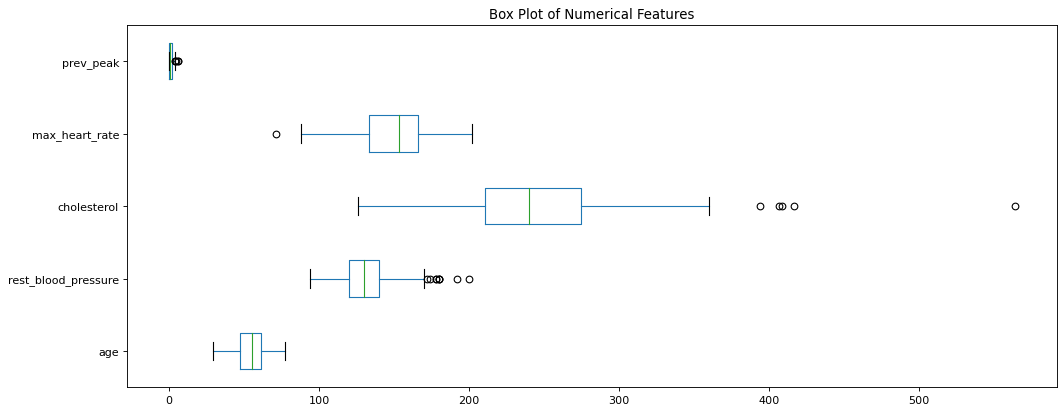

In [18]:
fig, ax = plt.subplots(figsize = (15,6), dpi = 80)
df.drop(columns = 'output').plot(kind = 'box', 
                                 vert = False, 
                                 ax = ax, 
                                 logx = False, 
                                 title = 'Box Plot of Numerical Features'
);

* It can be seen that features `prev_peak`, `max_heart_rate`, `cholesterol` and `rest_blood_pressure` have observations outside the 1.5x multiple of the Interquartile Range (IQR), which is the region inside the box i.e. between 25th and 75th percentile.
* These outliers need to be removed

### Removing Outliers
* observations which lie outside the 1.5x the Interquartile Range (IQR) on either side would be removed
* Source for the outliers code [stackoverflow](https://stackoverflow.com/questions/35827863/remove-outliers-in-pandas-dataframe-using-percentiles)

In [19]:
# Specifying columns from where outliers need to be removed
cols = ['prev_peak', 'max_heart_rate', 'cholesterol', 'rest_blood_pressure']
# Specifying Interquartile Range
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1
# Removing values which lie outside 1.5x of the IQR on either side
df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print('The shape of modified DataFrame is', df.shape)

The shape of modified DataFrame is (284, 14)


### Checking for Multicollinearity
* Multicollinearity occurs when features are not independent and are highly correlated with each other
* One of the models to be used for binary classification is Logistic Regression
    * Logistic Regression models, although used for Classification, are in the same group as other Linear Models
    * That is why any correlation must be eliminated before model building
    * Correlation between features will cause Confirmation bias, and might lead to skewed predictions

#### Correlation Heatmap for Numerical Features

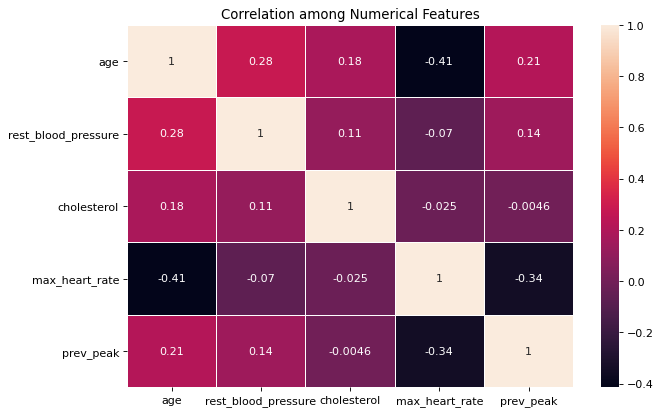

In [20]:
# Checking correlation for numerical features and dropping target vector `output`
correlation = df.select_dtypes('number').drop(columns = 'output').corr()
# Plotting correlation heatmap from seaborn
plt.figure(figsize = (9,6), dpi = 80)
plt.title('Correlation among Numerical Features')
ax = sns.heatmap(correlation, annot = True, linewidths = 0.5);

* It turns out that the numerical features have **weak positive or negative correlation** among themselves
* So no numerical feature columns need to be dropped
* Since there is no outrageous correlation between numerical features, **Logistic Regression could be used** as one of the models

## 1.3 Splitting Data
### Vertical Splitting

In [21]:
# Specifying the Target Vector
target = 'output'
# Specifying the Feature Matrix
X = df.drop(columns = target)
y = df[target]

print('X shape:', X.shape)
print('y shape', y.shape)

X shape: (284, 13)
y shape (284,)


### Horizontal Splitting (Randomised Train-Test Split)
* Performing a randomised train-test split in 80:20 ratio

In [22]:
# Randomly Splitting data into test (80%) and training (20%) sets. Setting `random_state` as 108
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 108
)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (227, 13)
y_train shape: (227,)
X_test shape: (57, 13)
y_test shape: (57,)


# 2. Building Models
## 2.1 Baselining
### Baseline Accuracy Score

In [23]:
acc_baseline = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', round(acc_baseline, 4))

Baseline Accuracy: 0.5595


## 2.2 Iterating Models

### Logistic Regression
* **Sigmoid function** That's what the curve looks like. 
* The output is a probability between 0-1
* Any prediction above cutoff line (generally 0.5) is part of Positive Class (1) i.e. **More chance** of Heart-Attack
* Any prediction below cutoff line is part of Negative Class (0) i.e. **Less chance** of Heart-Attack
* **Cost Function** for a Logistic Regression model is Distance, because it is essentially mapping Linear Relationships
* It is a type of **Parametric Model**, which means that number of parameters remain fixed
* **CONVERGENCE WARNING**
    * This is common with Logistic Regression models. It shows that maximum number of default iterations was reached before model converged at an outcome
    * Using `max_iter` to raise number of iterations

In [24]:
# Building a Logistic Regression Model
model_1 = make_pipeline(
    OneHotEncoder(), # for encoding categorical features
    LogisticRegression(max_iter = 10000),# Setting maximum iterations to 10000 to avoid Convergence Warning
)

# Starting timer
start_1 = time.time()

# Fitting model to training data
model_1.fit(X_train, y_train)

# Stopping timer
elapsed_1 = time.time() - start_1

# Printing time elapsed
print(f'Training time:{elapsed_1 : .3f}s')

Training time: 0.203s


### Random Forest Classifier
* It is possible to have a more trustworthy prediction by using more than one model simultaneously.
* **Ensemble models** work by building multiple models on random subsets of the same data, and then comparing their predictions to make a final prediction.
* A collection or ensemble of decision trees is called a **RANDOM FOREST**.
* RANDOM FOREST employs a technique called **BAGGING** which means fitting multiple models (trained in parallel) on random subsets of data.
    * A forest of decision trees is created.
    * When it is time to make a prediction, each tree will cast its vote and the class with most votes becomes the final prediction.
    * These multiple decision trees in a random forest model won't be given access to all features, only a random subset of features (sq. root of total features).
    * By default the number of decision trees in a scikit random forest model is 100 `n_estimators`.
    * After the decision trees have been trained, they need to decide whether a patient is at a Higher Risk of Heart attack or Less risk
    * Each tree gets a vote, and the final prediction would be the category that gets the most votes

In [25]:
# Building a Random Forest classifier
clf_2 = make_pipeline(
    OneHotEncoder(), #for encoding categorical data
    RandomForestClassifier(random_state = 108)
)

#### Hyperparameter Grid
* Creating a dictionary `params` with the range of hyperparameters to be evaluated for Random Forest classifer
    * Experimenting with `max_depth` between 10 and 50 by steps of 5
    * Trying `n_estimators` between 20 and 100 by steps of 10

In [26]:
# Creating a dictionary `params`
params_2 = {
    'randomforestclassifier__n_estimators': range(20, 100, 10),
    'randomforestclassifier__max_depth': range(10, 50, 5)
}

#### Grid Search Cross-Validation (K-fold)
* 'K' in K-fold Cross Validation (CV) refers to the number of folds to divide data into. By default K (`cv` parameter) is usually 5.
* One of these folds is set aside as temporary validation set, and the remaining folds are used for training. Accuracy score is calculated.
* This process is repeated taking each fold as temporary validation set.
* In total there would be K accuracy scores. If the accuracy scores are close to each other, that means the model generalises well.

In [27]:
# creating a model which includes RandomForestClassifier and Hyperparameter Grid
model_2 = GridSearchCV(
    clf_2, # RandomForestClassifier
    param_grid = params_2, # Hyperparameter dictionary
    cv = 6, # Cross-Validation Folds
    n_jobs = -1, # Number of parallel jobs to undertake. -1 means use all processing power available
    verbose = 3 # Output to describe the progress of training process
)

#### Fitting Model to Training Data

In [28]:
# Starting timer
start_2 = time.time()

# Fitting model to training data
model_2.fit(X_train, y_train)

# Stopping timer
elapsed_2 = time.time() - start_2

# Printing time elapsed
print(f'Training time:{elapsed_2 : .3f}s')

Fitting 6 folds for each of 64 candidates, totalling 384 fits
Training time: 27.058s


#### Cross-Validation Results

In [29]:
# Extracting cross-validation results from model and loading them into DataFrame named `cv2_results`
cv2_results = pd.DataFrame(model_2.cv_results_)
# Sorting results by `rank_test_score to see top 5
cv2_results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
42,0.345050,0.033434,0.068450,0.009263,35,40,"{'randomforestclassifier__max_depth': 35, 'ran...",0.789474,0.815789,0.815789,0.842105,0.763158,0.945946,0.82871,0.057871,1
26,0.339935,0.035880,0.058305,0.002745,25,40,"{'randomforestclassifier__max_depth': 25, 'ran...",0.789474,0.815789,0.815789,0.842105,0.763158,0.945946,0.82871,0.057871,1
18,0.344322,0.021343,0.069287,0.007994,20,40,"{'randomforestclassifier__max_depth': 20, 'ran...",0.789474,0.815789,0.815789,0.842105,0.763158,0.945946,0.82871,0.057871,1
34,0.368145,0.033152,0.060465,0.008587,30,40,"{'randomforestclassifier__max_depth': 30, 'ran...",0.789474,0.815789,0.815789,0.842105,0.763158,0.945946,0.82871,0.057871,1
10,0.357538,0.031819,0.060471,0.002982,15,40,"{'randomforestclassifier__max_depth': 15, 'ran...",0.789474,0.815789,0.815789,0.842105,0.763158,0.945946,0.82871,0.057871,1


* Each row represents a different set of Hyperparameters used to train the model
* Information on time taken to train the model, on `mean_test_score`, the rank of test score can be observed.
* It can be seen that the **best hyperparameter** combination is the one with **highest `mean_test_score` and lowest standard deviation among test scores `std_test_score`

#### Extracting Best Hyperparameters
**and best Test Accuracy Score**

In [30]:
model_2.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__n_estimators': 40}

* It turns out that more depth did not necessarily translate to better performance
* Neither did increasing number of estimators led to better performance

In [31]:
model_2.best_score_

0.828710289236605

### Gradient Boosting Trees Classifier
* In a **Boosting** model, multiple models are fitted in sequence using all of Training data
* STEP 1:
    * Fit a decision tree to training data. This decision tree is a `weak learner` i.e. it is not so good at making predictions.
    * After fitting, residuals are calculated for this tree. The set of residuals R1 is obtained.
* STEP 2:
    * A second tree is fitted on the residuals of previous tree. 
    * Tree2 is trying to predict how far from actual values were the predictions of Tree1, so that it can improve on those predictions.
    * Residuals are calculated again. This time focus is on difference between true residuals of tree1, and Tree2 predictions of those residuals.
    * This new set of residuals is R2.
* STEP 3:
    * The process is repeated with a Tree3, and residuals are calculated again.
* STEP 4:
    * This process is repeated 100 times by default in scikit-learn. 
    * Everytime the model adds a new tree, it improves upon the previous tree's prediction.
    * This generates an ensemble of weak learners chained together, each improving on the last one's predictions. This improves overall predictions.

In [32]:
# Creating a clf_3 object with GradientBoostingClassifer predictor
clf_3 = make_pipeline(
    OneHotEncoder(), # for encoding Categorical Data
    GradientBoostingClassifier()
)

#### Hyperparameter Grid
* Creating a dictionary with a range of hyperparameters to evaluate for `clf_3`.
* For GradientBoosting Classifier:
    * Experimenting with `max_depth` between 2 and 5. It is better to keep trees shallow, because this is a resource intensive algorithm, and also to avoid Overfitting.
    * Iterating `n_estimators` between 20 and 100, by steps of 5.
* `learning_rate` (floating value) in GradientBoostingClassifier shrinks the contribution of each tree by that amount. 
* There exists a trade-off between `learning_rate` and `n_estimators`.

In [33]:
# Initiating params_3 dictionary
params_3 = {
    'gradientboostingclassifier__n_estimators': range(20, 100, 5),
    'gradientboostingclassifier__max_depth': range(2, 5)
}

#### Grid Search Cross-Validation

In [34]:
# Creating a GradientBoostingClassifier model
model_3 = GridSearchCV(
    clf_3, # GradientBoosting Classifier
    param_grid = params_3, # Hyperparameter Grid
    cv = 6, # Number of folds in Cross-Validation
    n_jobs = -1, # Number of parallel jobs to undertake
    verbose = 3 # Output to describe the progress of training process
)

#### Fitting Model to Training Data

In [35]:
# Starting timer
start_3 = time.time()

# Fitting model to training data
model_3.fit(X_train, y_train)

# Stopping timer
elapsed_3 = time.time() - start_3

# Printing time elapsed
print(f'Training time:{elapsed_3 : .3f}s')

Fitting 6 folds for each of 48 candidates, totalling 288 fits
Training time: 13.966s


#### Cross Validation Results

In [36]:
# Extracting cross-validation results from `model_3` and loading them into DataFrame named `cv3_results`
cv3_results = pd.DataFrame(model_3.cv_results_)
# Sorting results by `rank_test_score to see top 5
cv3_results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
9,0.278244,0.019591,0.062790,0.006224,2,65,"{'gradientboostingclassifier__max_depth': 2, '...",0.736842,0.868421,0.842105,0.815789,0.763158,0.810811,0.806188,0.044604,1
10,0.277754,0.008025,0.059468,0.011198,2,70,"{'gradientboostingclassifier__max_depth': 2, '...",0.736842,0.868421,0.842105,0.815789,0.763158,0.810811,0.806188,0.044604,1
4,0.287002,0.040217,0.058397,0.006513,2,40,"{'gradientboostingclassifier__max_depth': 2, '...",0.763158,0.868421,0.815789,0.789474,0.736842,0.837838,0.801920,0.044342,3
5,0.251847,0.029960,0.052830,0.003407,2,45,"{'gradientboostingclassifier__max_depth': 2, '...",0.763158,0.868421,0.815789,0.789474,0.763158,0.810811,0.801802,0.036179,4
7,0.291781,0.028829,0.056187,0.007816,2,55,"{'gradientboostingclassifier__max_depth': 2, '...",0.763158,0.868421,0.815789,0.789474,0.763158,0.810811,0.801802,0.036179,4


#### Extracting Best Hyperparameters
**and best Accuracy Scores**

In [37]:
model_3.best_params_

{'gradientboostingclassifier__max_depth': 2,
 'gradientboostingclassifier__n_estimators': 65}

In [38]:
model_3.best_score_

0.8061877667140824

## 2.3 Evaluating Models

### Logistic Regression `model_1`

#### Classification Report
* Note: Here, **Positive Class is 1** i.e More Chance of Heart Attack. And **Negative Class is 0** i.e. Less Chance of Heart Attack.
* **True Positives (TP):** If the original target is 1, and the predictor also predicts 1. i.e. *Correctly predicting that a patient has a higher chance of heart attack.*
* **True Negatives (TN):** If the original target is 0, and the predictor also predicts 0. i.e. *Correctly predicting that a patient has a less chance of heart attack.*
* **False Positives (FP):** If the original target is 0, but the predictor predicts 1. i.e. *Incorrectly predicting that a patient has a higher chance of heart attack.*
* **False Negatives (FN):** If the original target is 1, but the predictor predicts 0. i.e. *Incorrectly predicting that a patient has a less chance of heart attack.*


* **Accuracy Score**:
    * **Accuracy = (TP + TN) / (TP + TN + FP + FN)**
    * It is the number of Correct Predictions divided by Total Samples.
    * Here Accuracy implies the total number of patients who were correctly predicted to be at a higher (1) or a lower (0) risk of a heart attack.     
* **Precision Score**:
    * **Precision = (TP) / (TP + FP)**
    * It measure how well the model identifies observations that belong to Positive Class, WITHOUT making the error of FALSE POSITIVE.
    * Higher Precision means, less number of False Positives are being predicted. This is critical for serious life threatening diagnosis e.g. when predicting whether someone has Cancer, or when a substantial amount of investment is at stake e.g. whether an entity is going to default on a loan or not.
    * The Probability Threshold (which by default is at 0.5) is switched higher to decrease the number of False Positives.
* **Recall Score**:
    * **Recall = (TP) / (TP + FN)**
    * It measures how well the model identifies observations that belong to Positive Class.
    * **Also known as True Positive Rate and Sensitivity**
    * A model that prioritises Recall, will cast the widest possible net to catch all observations which could belong to Positive Class. 
    * For a bank, a higher Recall score would be useful to filter out entities at the highest risk of a default. So that they could be given a precautionary warning.
    * For our case, a higher Recall Score would indeed be helpful, as it might encourage patients to make lifestyle changes which would ultimately improve their health in the long-term.
* **F1 Score**:
    * **F1 = (2.Recall.Precision) / (Recall + Precision)** or
    * **F1 = (2TP) / (2TP + FP + FN)**
    * It is a weighted average of Precision and Recall Metrics
    
* All these Performance metrics have values between 0 and 1.
* A Classification Report provides all these metrics.

In [39]:
# Checking Performance Metrics for Logistic Regression `model_1`
print(classification_report(y_test, model_1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82        25
           1       0.82      0.97      0.89        32

    accuracy                           0.86        57
   macro avg       0.88      0.84      0.85        57
weighted avg       0.87      0.86      0.86        57



**Observations**:
* This model was able to beat Baseline Accuracy (0.55).
* It can be seen that Logistic Regression model is attempting to capture all patients at the highest risk of Heart Attack, which is good.
* This is Reflected in its High Recall Score for Positive Class (0.97).
* The model has a decent Accuracy as well (0.86).
* It certainly seems like a good model.

#### Confusion Matrix
* A visual way to depict counts of TP, TN, FP and FN
* **Top-Right : False Positives**
* **Top-Left : True Negatives**
* **Bottom-Left : False Negatives**
* **Bottom-Right : True Positives**

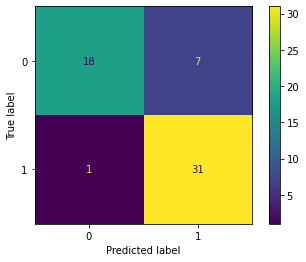

In [40]:
# Confusion Matrix for `model_1`
ConfusionMatrixDisplay.from_estimator(model_1, X_test, y_test);

* 31 observations were correctly predicted to be at a higher risk of heart-attack by our model.
* The model also did well to minimise cases (1) which were at a high risk of heart attack but were incorrectly classified as being fine.

#### AUC and ROC Curve
* **True Positive Rate (TPR):**
    * **TPR = TP / (TP + FN)**
    * aka **Recall**. Both TPR and Recall refer to the same metric. and measure the Sensitivity.
* **False Positive Rate (FPR):**
    * **FPR = FP / (TN + FP)**
* **Receiver Operating Characteristic (ROC) Curve:**
    * Simply put, ROC Curve is the plotted curve between FPR and TPR at various probability cutoff thresholds.
    * In case of an imbalanced target class, it might make sense to plot Precision vs TPR, because Precision is unaffected by imbalance. 
    * Essentially, ROC is an alternative to making Confusion Matrices for every probability threshold.
    * The choice of optimal threshold depends on how many False Positives can be tolerated.
* **Area Under the Curve (AUC)**
    * Area under ROC Curve is AUC
    * AUC makes it easier to compare one ROC Curve to another
    * The higher the AUC value, the better the model
        * AUC = 1.0 -> Very Good Model
        * AUC = 0.5 -> Random Model (A diagonal line)

Logistic Regression Model: AUROC = 0.953


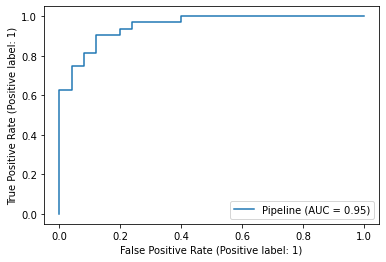

In [41]:
model_1_proba = model_1.predict_proba(X_test)
model_1_proba = model_1_proba[:,[1]]
model_1_auc = roc_auc_score(y_test, model_1_proba)
model_1_disp = RocCurveDisplay.from_estimator(model_1, X_test, y_test)

print('Logistic Regression Model: AUROC = %.3f' % (model_1_auc))

* AUC for `model_1` is about 0.95, which suggests that Logistic Regression could be a very decent model for our purpose.
* As one moves from right to left on the ROC Curve, the False Positive Rate can be seen declining.
* Movement on the left means increasing probability threshold, which means less likelihood of including borderline patients which were incorrectly predicted to be at a Higher Risk of a Heart Attack.
* The point at (0,0) represents a threshold with Zero TP and Zero FP

#### Log loss
* Log loss penalises wrong predictions
* The lower the log loss, the better the model

In [43]:
# Calculating log loss
log_loss(y_test, model_1_proba)

0.29717497674473137

#### Training Time
* For practical reasons, it is best to have a model which is less resource intensive, and is decently accurate at the same time
* When choosing between models with marginal difference in other scores, it is better to pick a model which is faster to train

In [44]:
# Checking Training Time for `model_1`
print(f'Training time for Logistic Regression Model:{elapsed_1 : .3f}s')

Training time for Logistic Regression Model: 0.203s


### Random Forest `model_2`

#### Classification Report

In [45]:
# Checking Performance Metrics for Random Forest `model_2`
print(classification_report(y_test, model_2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85        25
           1       0.86      0.94      0.90        32

    accuracy                           0.88        57
   macro avg       0.88      0.87      0.87        57
weighted avg       0.88      0.88      0.88        57



**Observations**:
* Random Forest model was also able to beat Baseline Accuracy (0.55).
* It can be seen that this model has a higher Precision (0.86) than Logistic Regression model (0.82). It manages to minimise the number of False Positives.

#### Confusion Matrix

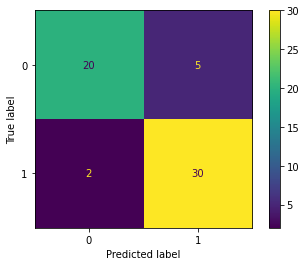

In [46]:
# Confusion Matrix for `model_2`
ConfusionMatrixDisplay.from_estimator(model_2, X_test, y_test);

#### AUC and ROC Curve

Random Forest Model: AUROC = 0.950


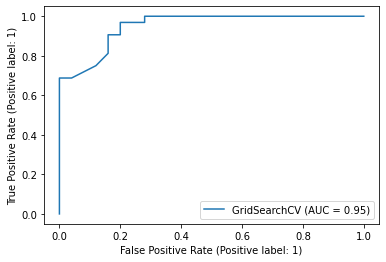

In [47]:
model_2_proba = model_2.predict_proba(X_test)
model_2_proba = model_2_proba[:,[1]]
model_2_auc = roc_auc_score(y_test, model_2_proba)
model_2_disp = RocCurveDisplay.from_estimator(model_2, X_test, y_test)

print('Random Forest Model: AUROC = %.3f' % (model_2_auc))

* Interestingly, Random forest `model_2` has almost the same AUC as Linear Regression `model_1`
* But its ROC Curve is a bit different in shape. Curves need to be seen together to get a clearer picture

#### Log loss

In [48]:
# Calculating log loss
log_loss(y_test, model_2_proba)

0.3010270713653839

* This is marginally higher than Logistic Regression `model_1`, which is okay but not too great

#### Training Time

In [49]:
# Checking Training Time for `model_2`
print(f'Training time for RandomForest Model:{elapsed_2 : .3f}s')

Training time for RandomForest Model: 27.058s


* This is a very resource intensive model, it turns out. 
* But then, there were also 384 fits to make for it

### Gradient Boosting Trees `model_3`

#### Classification Report

In [50]:
# Checking Performance Metrics for Gradient Boosting Trees `model_3`
print(classification_report(y_test, model_3.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84        25
           1       0.84      0.97      0.90        32

    accuracy                           0.88        57
   macro avg       0.89      0.86      0.87        57
weighted avg       0.89      0.88      0.87        57



* Gradient Boosting Trees `model_3` trails `model_2` in Precision but beats it in Recall.
* `model_3` Recall is the same as `model_1`

#### Confusion Matrix

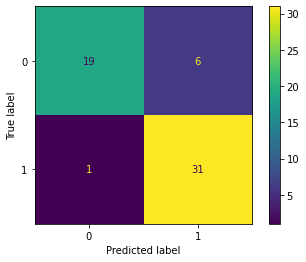

In [51]:
# Confusion Matrix for `model_3`
ConfusionMatrixDisplay.from_estimator(model_3, X_test, y_test);

#### AUC and ROC Curve

Gradient Boosting Trees Model: AUROC = 0.941


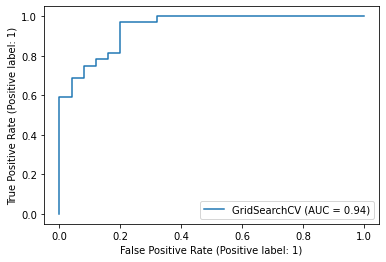

In [52]:
model_3_proba = model_3.predict_proba(X_test)
model_3_proba = model_3_proba[:,[1]]
model_3_auc = roc_auc_score(y_test, model_3_proba)
model_3_disp = RocCurveDisplay.from_estimator(model_3, X_test, y_test)

print('Gradient Boosting Trees Model: AUROC = %.3f' % (model_3_auc))

* It turns out that `model_3` has a marginally lower AUC than `model_1` and `model_2`

#### Log loss

In [53]:
log_loss(y_test, model_3_proba)

0.3233837126586226

* This is a tiny bit higher than both Logistic Regression `model_1` and Random Forest `model_2`, which is not too good.

#### Training Time

In [54]:
# Checking Training Time for `model_3`
print(f'Training time for Gradient Boosting Trees Model:{elapsed_3 : .3f}s')

Training time for Gradient Boosting Trees Model: 13.966s


* Almost twice as faster when compared to Random Forest Model (`model_2`), but then it had less fits to make (288).
* It still takes more than **60 times higher resources to train `model_3` when compared with Logistic Regression Model (`model_1`)**.

### Comparing AUC for all models

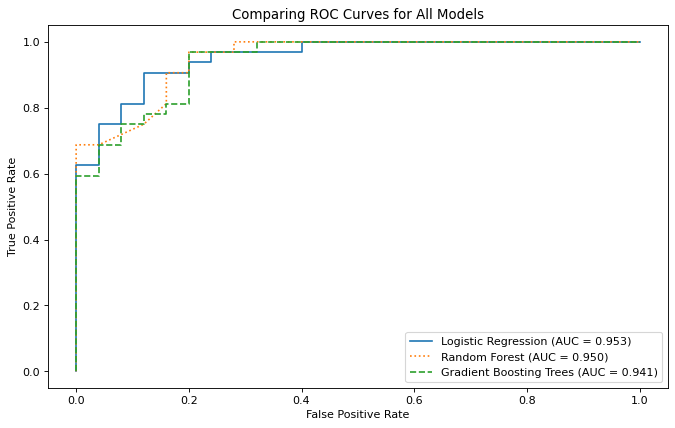

In [61]:
# Calculating ROC curves for each model 
# `model_fpr` is model's False Positive Rate
# `model_tpr` is model's True Positive Rate
# `threshold` is the variable probability 

model_1_fpr, model_1_tpr, threshold = roc_curve(y_test, model_1_proba)
model_2_fpr, model_2_tpr, threshold = roc_curve(y_test, model_2_proba)
model_3_fpr, model_3_tpr, threshold = roc_curve(y_test, model_3_proba)

# Plotting ROC Curves for all models

plt.figure(figsize = (10, 6), dpi = 80)
plt.plot(model_1_fpr, model_1_tpr,
         linestyle = 'solid',
         label = 'Logistic Regression (AUC = %0.3f)' % model_1_auc
)
plt.plot(model_2_fpr, model_2_tpr,
         linestyle = 'dotted',
         label = 'Random Forest (AUC = %0.3f)' % model_2_auc 
)
plt.plot(model_3_fpr, model_3_tpr,
         linestyle = 'dashed',
         label = 'Gradient Boosting Trees (AUC = %0.3f)' % model_3_auc 
)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparing ROC Curves for All Models')
plt.legend()
plt.show()

**Observations**
* Imagine a vertical line at 0.3 FPR. 
* Random Forest Model is the last to start its movement downwards, which means that `model_2` is able to minimise False Positives most efficiently. This can also be seen in its higher Precision score compared to other models.
* But as the probability threshold is raised further to include, less and less False Negatives, somewhere between 0.1 and 0.2 FPR, `model_2` suffers a performance breakdown, and cedes the leadership to Logistic Regression `model_1`
* This implies that at higher probability thresholds, Logistic Regression does a better job at giving higher Precision Scores (minimising FP)

# 3. Communicating Results
### Logistic Regression `model_1` wins

* Logistic Regression `model_1` emerges as the overall winner for the model of choice to predict whether a patient is at a higher risk of Heart Attack or not.
* There were many elements which worked in its favour:
    * Highest AUC 
    * Lowest log loss
    * Highest Recall Score (Our Preference because we wish to seek the widest possible net to warn all at potential risk)
    * **AND ABOVE ALL, BECAUSE IT TOOK THE LEAST RESOURCES TO TRAIN**

### Extracting Feature Names and Importances

In [57]:
# Feature names and Importances for Logistic Regression `model_1`
features = model_1.named_steps['onehotencoder'].get_feature_names()
importances = model_1.named_steps['logisticregression'].coef_[0]

### Odds Ratios
* Odds Ratio over 1 for a feature, increases the likelihood of a patient getting heart attack.
* Odds Ratio close to 0 for a feature decreases the likelihood of a heart attack.

In [59]:
# Creating a pandas series `odds ratios`
odds_ratios = pd.Series(np.exp(importances), index = features).sort_values()

#### Plotting Odds Ratios for Highest Coefficients

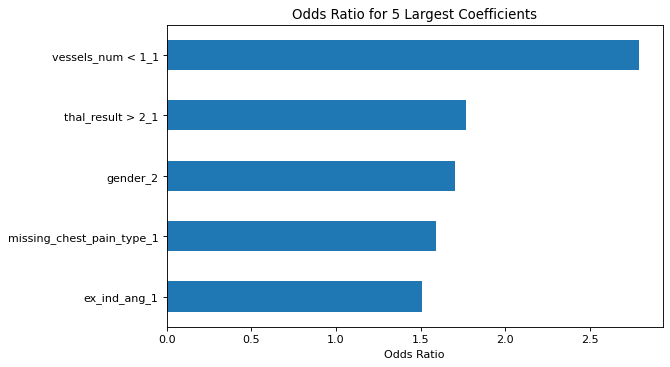

In [63]:
# Horizontal bar charting for five largest coefficients
plt.figure(figsize = (8, 5), dpi = 80)
odds_ratios.tail().plot(kind = 'barh')
plt.xlabel('Odds Ratio')
plt.title('Odds Ratio for 5 Largest Coefficients');

**Interpretation**
* All else being equal:
    * If the Number of major vessels (`vessels_num`) for a patient is **LESS THAN 1**, then they are almost **200% more likely** to have a heart attack.
    * If the Thalium Stress Test Result (`thal_result`) for a patient is **LESS THAN 2**, then they are about **80% more likely** to have a heart attack.
    * The **Gender 0** is almost **70% more likely** to have a heart attack.

#### Plotting Odds Ratios for Smallest Coefficients

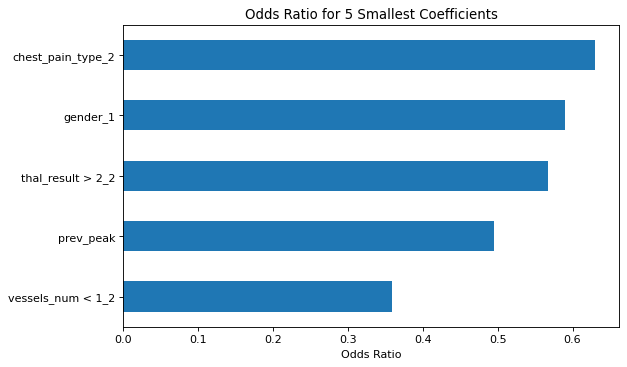

In [64]:
# Horizontal bar charting for five Smallest coefficients
plt.figure(figsize = (8, 5), dpi = 80)
odds_ratios.head().plot(kind = 'barh')
plt.xlabel('Odds Ratio')
plt.title('Odds Ratio for 5 Smallest Coefficients');

**Interpretation**
* All else being equal:
    * If the Number of major vessels (`vessels_num`) for a patient is **MORE THAN 1**, then they are almost **65% less likely** to have a heart attack.
    * If the Thalium Stress Test Result (`thal_result`) for a patient is **MORE THAN 2**, then they are about **45% less likely** to have a heart attack.
    * The **Gender 1** is almost **40% less likely** to have a heart attack.

## Saving Model

In [65]:
import pickle
with open('heart-attack-lr.pkl', 'wb') as f:
    pickle.dump(model_1, f)

'wb' is about permissions. 'w' means write, 'b' means binary mode, which is used when reading/writing to a type of file which can not be opened in a text editor.

### Final Comments for Self
* It was surprising that a simple linear model, such as Logistic Regression could outperform Tree Based Classifiers.
* Perhaps with more feature engineering, an even better prediction accuracy could have been achieved.
* It would be interesting to test Other classifiers such as Naive Bayes and Support Vector Machines (SVM), to compare the perfomance.
* Admittedly, the code could have been written more efficiently. But we will get there in due time.